# Predictive Modeling for Prediabetes Detection

## How accurately can a machine learning model predict the early sign of prediabetes in individuals with normal blood sugar level?

### 1. Problem Definition and Scoping

**The Challenge:** Prediabetes (Class 1) is a critical "window of opportunity" for medical intervention, yet it is difficult to detect. In standard data models, this group is often overlooked resulting in a zero detection rate because their health markers are easily confused with healthy individuals.

**The Solution:** We developed a specialized Logistic Regression model using the UCI dataset, specifically optimized to find the "invisible" prediabetic population. We enhanced the model’s predictive power by introducing new features such as a Lifestyle Score and a Cardiovascular Interaction (High Blood Pressure + High Cholesterol), allowing for the detection of subtle diagnostic signals.


#### Rationale

Prediabetes is defined as higher blood sugar level than normal, but not high enough to be diagnosed as Type 2 Diabetes. Approximately 98 million American adults have prediabetes, and 8 in 10 adults do not know that they have the condition.

The early detection of prediabetes is especially important because prediabetes represents a reversible stage where lifestyle changes can successfully avoid permanent systemic complications. Early intervention can reduce the risk of progressing to Type 2 Diabetes (T2D). Early detection reduces the staggering healthcare burden associated with treating T2D complications, such as kidney failure, blindness, and cardiovascular disease.

#### Research Question

How accurately can a machine learning model predict the early sign of prediabetes in individuals with normal blood sugar level?

#### Data Sources

The diabetes dataset is available in the UC Irvine repository - https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators. The data contains health information, survey data, and demographics about people along with their diagnosis of prediabetes/diabetes. The person's weight, age, clinical biomarkers, and lifestyle habits are among the determinants of prediabetes risk.
 
#### Methodology

To model prediabetes using logistic regression, our analysis will include the essential steps to prepare the dataset with exploratory data analysis (EDA), data cleaning and preprocessing, visual plotting, feature binning, and feature engineering. We will also apply normalization, using techniques like StandardScaler to handle features on different scales. To identify the most significant risk factors, such as High Blood Pressure, BMI, High Cholesterol, etc., we will utilize feature selection methods like L1 Regularization. This approach integrates feature selection directly into the modeling process, penalizing less impactful variables not only to enhance the model and prevent overfitting but also highlights the feature importance of our primary predictors. Finally, we will evaluate the model’s performance using a confusion matrix to calculate accuracy, precision, recall and the F1-score. Additionally, the Confusion Matrix and the Area Under the Curve (ROC-AUC) will be used to measure the model's overall ability to distinguish between prediabetic and healthy individuals.


### 2. Data Collection and Sourcing


- UC Irvine Machine Learning Repository: https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators.

- Kaggle: Diabetes Health Indicators Dataset - https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

  3 classes: diabetes_012_health_indicators_BRFSS2015.csv

- CSV - https://archive.ics.uci.edu/static/public/891/data.csv

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import classification_report, accuracy_score, recall_score
from sklearn.dummy import DummyClassifier  

# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline

import time 

import warnings
# Hide the "Unknown categories" warning specifically
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.preprocessing._encoders")


In [2]:
#UCI fetch instruction is available here:
# https://github.com/uci-ml-repo/ucimlrepo

# Fetch UCI repo
# run pip install fetch_ucirepo in Anaconda Prompt
from ucimlrepo import fetch_ucirepo 

  
# Fetch object from uci repo
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

#cdc_diabetes_health_indicators.data.original  # The complete dataset (features + targets combined)

#### How to access the UCI DataFrame object : `cdc_diabetes_health_indicators`

To perform analysis, we need to access the specific **pandas DataFrames** stored within its attributes:

- `.data.features` - All input variables (e.g., HighBP, BMI, Smoker)
- `.data.targets` - The target variable (Diabetes_binary)
- `.data.original` - The full dataset (Features + Targets combined)

- `.metadata` - Dictionary type. Dataset description, source, and licensing

| Attribute | Content Type | What it contains |
| :--- | :--- | :--- |
| **`.data.features`** | `pandas.DataFrame` | All input variables (e.g., HighBP, BMI, Smoker) |
| **`.data.targets`** | `pandas.DataFrame` | The target variable (Diabetes_binary) |
| **`.data.original`** | `pandas.DataFrame` | The full dataset (Features + Targets combined) |
| **`.metadata`** | `dict` | Dataset description, source, and licensing |

---
**Tip:** Use `cdc_diabetes_health_indicators.data.original.head()` to quickly preview the entire dataset.

In [3]:
# Get the Original UCI Dataset - with complete (features + targets combined) and save in DataFrame for download locally
orig_diabetes_df = cdc_diabetes_health_indicators.data.original

# Save the CSV in the local directory /data folder for easier access
orig_diabetes_df.to_csv('data/cdc_prediabetes_uci_orig.csv', index=False)

#### DataFrame CSV Read Local

In [4]:
# Read the local CSV dataset that was downloaded in  Diabetes Health Indicators Dataset in Kaggle
# This is data that we will use for this project
prediabetes_df = pd.read_csv('data/cdc_prediabetes.csv')

### 3. Exploratory Data Analysis (EDA)


In [5]:
# Display the table information of each feature variables on UCI dataset
pd.set_option('display.max_colwidth', None)     #Fix for DataFrame width

cdc_diabetes_health_indicators.variables


,name,role,type,demographic,description,units,missing_values
0,ID,ID,Integer,None,Patient ID,None,no
1,Diabetes_binary,Target,Binary,None,0 = no diabetes 1 = prediabetes or diabetes,None,no
2,HighBP,Feature,Binary,None,0 = no high BP 1 = high BP,None,no
3,HighChol,Feature,Binary,None,0 = no high cholesterol 1 = high cholesterol,None,no
4,CholCheck,Feature,Binary,None,0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years,None,no
5,BMI,Feature,Integer,None,Body Mass Index,None,no
6,Smoker,Feature,Binary,None,Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes,None,no
7,Stroke,Feature,Binary,None,(Ever told) you had a stroke. 0 = no 1 = yes,None,no
8,HeartDiseaseorAttack,Feature,Binary,None,coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes,None,no
9,PhysActivity,Feature,Binary,None,physical activity in past 30 days - not including job 0 = no 1 = yes,None,no


In [6]:
# Display DataFrame and all columns 
pd.set_option('display.max_columns', None)

prediabetes_df.head(10)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
6,0.0,1.0,0.0,1.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,14.0,0.0,0.0,9.0,6.0,7.0
7,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,11.0,4.0,4.0
8,2.0,1.0,1.0,1.0,30.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,5.0,1.0
9,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,4.0,3.0


In [7]:
# Update columns: lowercase and remove spaces if any - safety net
prediabetes_df.columns = prediabetes_df.columns.str.replace(' ', '_')    #if any spaces
prediabetes_df.columns = prediabetes_df.columns.str.lower()


In [8]:
# Show DataFrame informations
prediabetes_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   diabetes_012          253680 non-null  float64
 1   highbp                253680 non-null  float64
 2   highchol              253680 non-null  float64
 3   cholcheck             253680 non-null  float64
 4   bmi                   253680 non-null  float64
 5   smoker                253680 non-null  float64
 6   stroke                253680 non-null  float64
 7   heartdiseaseorattack  253680 non-null  float64
 8   physactivity          253680 non-null  float64
 9   fruits                253680 non-null  float64
 10  veggies               253680 non-null  float64
 11  hvyalcoholconsump     253680 non-null  float64
 12  anyhealthcare         253680 non-null  float64
 13  nodocbccost           253680 non-null  float64
 14  genhlth               253680 non-null  float64
 15  

In [9]:
# Show summary statistics
prediabetes_df.describe().T                 # to get the ['mean'] only

,count,mean,std,min,25%,50%,75%,max
diabetes_012,253680.0,0.296921,0.698160,0.0,0.0,0.0,0.0,2.0
highbp,253680.0,0.429001,0.494934,0.0,0.0,0.0,1.0,1.0
highchol,253680.0,0.424121,0.494210,0.0,0.0,0.0,1.0,1.0
cholcheck,253680.0,0.962670,0.189571,0.0,1.0,1.0,1.0,1.0
bmi,253680.0,28.382364,6.608694,12.0,24.0,27.0,31.0,98.0
smoker,253680.0,0.443169,0.496761,0.0,0.0,0.0,1.0,1.0
stroke,253680.0,0.040571,0.197294,0.0,0.0,0.0,0.0,1.0
heartdiseaseorattack,253680.0,0.094186,0.292087,0.0,0.0,0.0,0.0,1.0
physactivity,253680.0,0.756544,0.429169,0.0,1.0,1.0,1.0,1.0
fruits,253680.0,0.634256,0.481639,0.0,0.0,1.0,1.0,1.0


###  Inspect colums, unique values and counts
- inspect columns
- inspect value and value counts for binary features 0 and 1, we can also catch if there are values like NaN or "Unknown"

In [10]:
# List all column names to inspect that we can use for processing
prediabetes_df.columns

Index(['diabetes_012', 'highbp', 'highchol', 'cholcheck', 'bmi', 'smoker',
       'stroke', 'heartdiseaseorattack', 'physactivity', 'fruits', 'veggies',
       'hvyalcoholconsump', 'anyhealthcare', 'nodocbccost', 'genhlth',
       'menthlth', 'physhlth', 'diffwalk', 'sex', 'age', 'education',
       'income'],
      dtype='object')

In [11]:
# Check and verify unique values in each column that are out of range
print(prediabetes_df.nunique())

diabetes_012             3
highbp                   2
highchol                 2
cholcheck                2
bmi                     84
smoker                   2
stroke                   2
heartdiseaseorattack     2
physactivity             2
fruits                   2
veggies                  2
hvyalcoholconsump        2
anyhealthcare            2
nodocbccost              2
genhlth                  5
menthlth                31
physhlth                31
diffwalk                 2
sex                      2
age                     13
education                6
income                   8
dtype: int64


- bmi - seems to be high, investigate further
- menthlth and physhlth seems to be ok, 31 for number of days in a month
- genhlth, age, education and income are ok, they were scaled in group

In [12]:
# Target variable unique value and counts
prediabetes_df['diabetes_012'].value_counts()

# class 0 no diabetes
# class 1 prediabetes
# class 2 diabetes

diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64

In [13]:
# Unique values and count for High Blood Pressure
prediabetes_df['highbp'].value_counts()

highbp
0.0    144851
1.0    108829
Name: count, dtype: int64

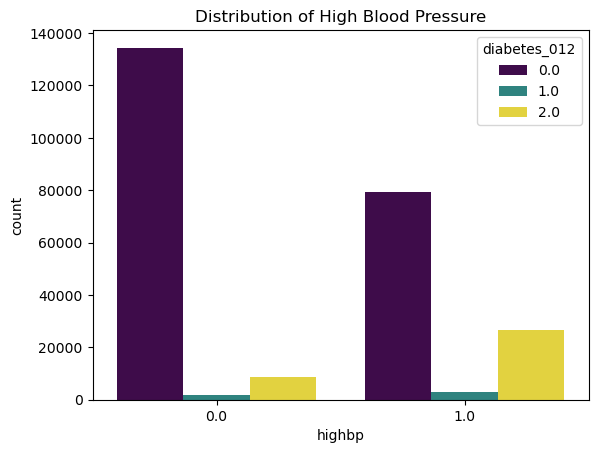

In [14]:
sns.countplot(x='highbp', data=prediabetes_df, hue='diabetes_012', palette='viridis')
plt.title('Distribution of High Blood Pressure')
plt.show()

- This shows the diabetes class breakdown for people with/without HighBP

In [15]:
# Unique values and count for High Cholesterol
prediabetes_df['highchol'].value_counts()  

highchol
0.0    146089
1.0    107591
Name: count, dtype: int64

In [16]:
# Unique values and count for Cholesterol Check
prediabetes_df['cholcheck'].value_counts()   

cholcheck
1.0    244210
0.0      9470
Name: count, dtype: int64

In [17]:
# Unique values and count for BMI
prediabetes_df['bmi'].value_counts()   

bmi
27.0    24606
26.0    20562
24.0    19550
25.0    17146
28.0    16545
        ...  
85.0        1
91.0        1
86.0        1
90.0        1
78.0        1
Name: count, Length: 84, dtype: int64

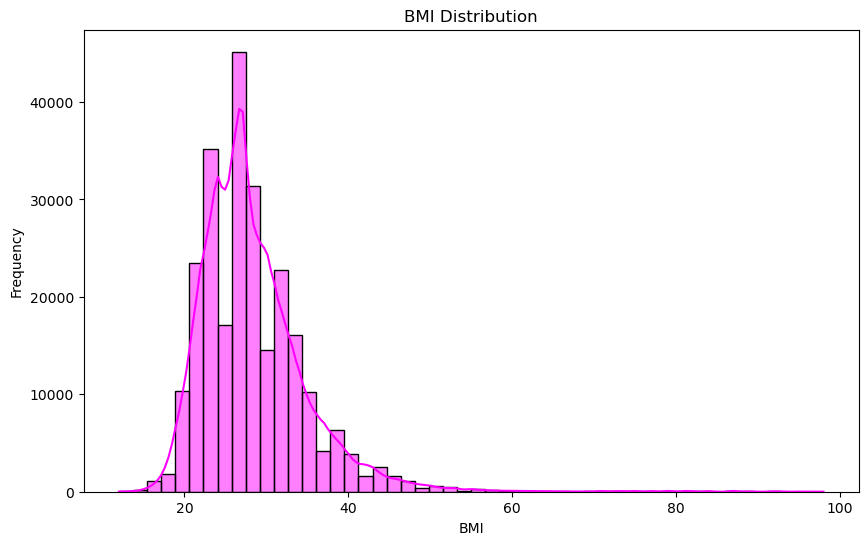

In [18]:
# BMI Distribution
plt.figure(figsize=(10, 6))
sns.histplot(prediabetes_df['bmi'], bins=50, kde=True, color='magenta')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

- This graph shows the BMI is Right-Skewed, most people are in the 20–30 range, but there is a long tail of very high BMI values. We can then verify and consider BMI > 60 are outliers.

In [19]:
# Unique values and count for Smoker
prediabetes_df['smoker'].value_counts()   

smoker
0.0    141257
1.0    112423
Name: count, dtype: int64

In [20]:
# Unique values and count for Stroke
prediabetes_df['stroke'].value_counts()   

stroke
0.0    243388
1.0     10292
Name: count, dtype: int64

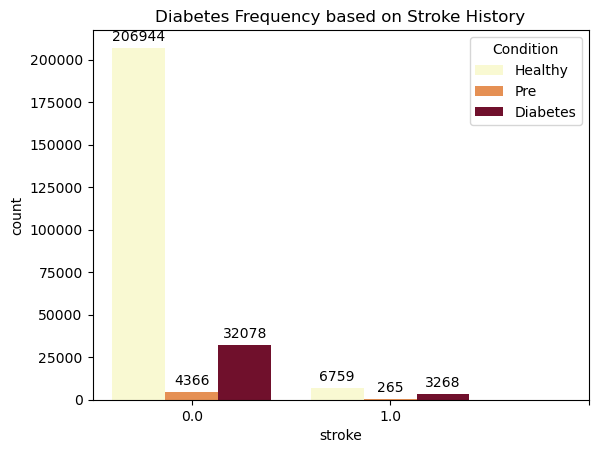

In [21]:
# Plotting Stroke and Diabetes
ax = sns.countplot(x='stroke', hue='diabetes_012', data=prediabetes_df, palette='YlOrRd') # 'viridis' "magma", or "YlOrRd"

# Show counts on top of the bars
# padding adds a little space
ax.set_xticks([0, 1, 2])
ax.bar_label(ax.containers[0], padding=3)
ax.bar_label(ax.containers[1], padding=3)
ax.bar_label(ax.containers[2], padding=3)

plt.title('Diabetes Frequency based on Stroke History')
plt.legend(title='Condition', labels=['Healthy', 'Pre', 'Diabetes'])

- This graph shows the relationship between Stroke and Diabetes
- Among individuals who have had a stroke, about 33% also have diabetes.

In [22]:
# Unique values and count for Heart Disease
prediabetes_df['heartdiseaseorattack'].value_counts()   

heartdiseaseorattack
0.0    229787
1.0     23893
Name: count, dtype: int64

In [23]:
# Unique values and count for physical activity
prediabetes_df['physactivity'].value_counts()   

physactivity
1.0    191920
0.0     61760
Name: count, dtype: int64

In [24]:
# Unique values and count for fruits
prediabetes_df['fruits'].value_counts()   

fruits
1.0    160898
0.0     92782
Name: count, dtype: int64

In [25]:
# Unique values and count for veggies
prediabetes_df['veggies'].value_counts()   

veggies
1.0    205841
0.0     47839
Name: count, dtype: int64

In [26]:
# Unique values and count for heavy alcohol consumption
prediabetes_df['hvyalcoholconsump'].value_counts()   

hvyalcoholconsump
0.0    239424
1.0     14256
Name: count, dtype: int64

In [27]:
# Unique values and count for no doctor because of cost
prediabetes_df['nodocbccost'].value_counts()   

nodocbccost
0.0    232326
1.0     21354
Name: count, dtype: int64

In [28]:
# Unique values and count for general health
prediabetes_df['genhlth'].value_counts()   

genhlth
2.0    89084
3.0    75646
1.0    45299
4.0    31570
5.0    12081
Name: count, dtype: int64

In [29]:
# Show percentages for general health

print(prediabetes_df['genhlth'].value_counts(normalize=True) * 100)   #Percentage

# 1 - excellent 
# 5 - poor

genhlth
2.0    35.116682
3.0    29.819458
1.0    17.856749
4.0    12.444812
5.0     4.762299
Name: proportion, dtype: float64


In [30]:
# Mental Health - how many days during the past 30 days was your mental health not good? scale 1-30 days
# Unique values and count
prediabetes_df['menthlth'].value_counts().sort_index()

# Note that there are individuals who reported high numbers -30 days - it often indicates chronic stress and depression

menthlth
0.0     175680
1.0       8538
2.0      13054
3.0       7381
4.0       3789
5.0       9030
6.0        988
7.0       3100
8.0        639
9.0         91
10.0      6373
11.0        41
12.0       398
13.0        41
14.0      1167
15.0      5505
16.0        88
17.0        54
18.0        97
19.0        16
20.0      3364
21.0       227
22.0        63
23.0        38
24.0        33
25.0      1188
26.0        45
27.0        79
28.0       327
29.0       158
30.0     12088
Name: count, dtype: int64

In [31]:
# Unique values and count for physical health
prediabetes_df['physhlth'].value_counts().sort_index()

physhlth
0.0     160052
1.0      11388
2.0      14764
3.0       8495
4.0       4542
5.0       7622
6.0       1330
7.0       4538
8.0        809
9.0        179
10.0      5595
11.0        60
12.0       578
13.0        68
14.0      2587
15.0      4916
16.0       112
17.0        96
18.0       152
19.0        22
20.0      3273
21.0       663
22.0        70
23.0        56
24.0        72
25.0      1336
26.0        69
27.0        99
28.0       522
29.0       215
30.0     19400
Name: count, dtype: int64

In [32]:
# Do you have serious difficulty walking or climbing stairs? 
# Unique values and count for difficulty walking
prediabetes_df['diffwalk'].value_counts()

diffwalk
0.0    211005
1.0     42675
Name: count, dtype: int64

In [33]:
# Unique values and count for sex
prediabetes_df['sex'].value_counts()

sex
0.0    141974
1.0    111706
Name: count, dtype: int64

In [34]:
# Age group
# Unique values and count
prediabetes_df['age'].value_counts().sort_index()

age
1.0      5700
2.0      7598
3.0     11123
4.0     13823
5.0     16157
6.0     19819
7.0     26314
8.0     30832
9.0     33244
10.0    32194
11.0    23533
12.0    15980
13.0    17363
Name: count, dtype: int64

In [35]:
# Education group
# Unique values and count
prediabetes_df['education'].value_counts()

education
6.0    107325
5.0     69910
4.0     62750
3.0      9478
2.0      4043
1.0       174
Name: count, dtype: int64

In [36]:
# Income group
# Unique values and count
prediabetes_df['income'].value_counts()

income
8.0    90385
7.0    43219
6.0    36470
5.0    25883
4.0    20135
3.0    15994
2.0    11783
1.0     9811
Name: count, dtype: int64

### Target Distribution Plot


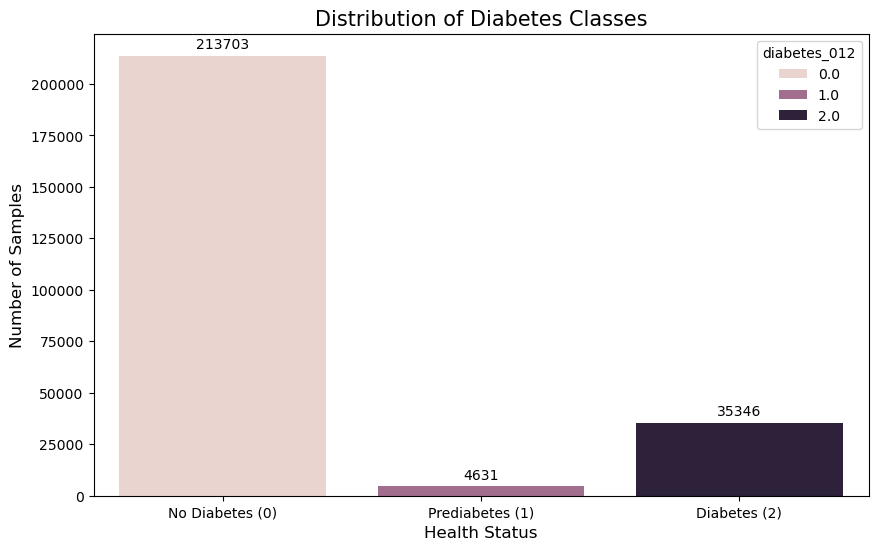

In [37]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='diabetes_012', data=prediabetes_df, hue='diabetes_012')

# Ticks and labels 
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['No Diabetes (0)', 'Prediabetes (1)', 'Diabetes (2)'])

# Counts on top of the bars
# Padding adds a little space
ax.bar_label(ax.containers[0], padding=3)
ax.bar_label(ax.containers[1], padding=3)
ax.bar_label(ax.containers[2], padding=3)

plt.title('Distribution of Diabetes Classes', fontsize=15)
plt.xlabel('Health Status', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)

# Save diabetes distribution image
plt.savefig('diabetes_distribution_class.png')

- The graph shows our diabetes distribution data and extreme imbalance between the three classes

### Distribution Plot for each Feature Columns

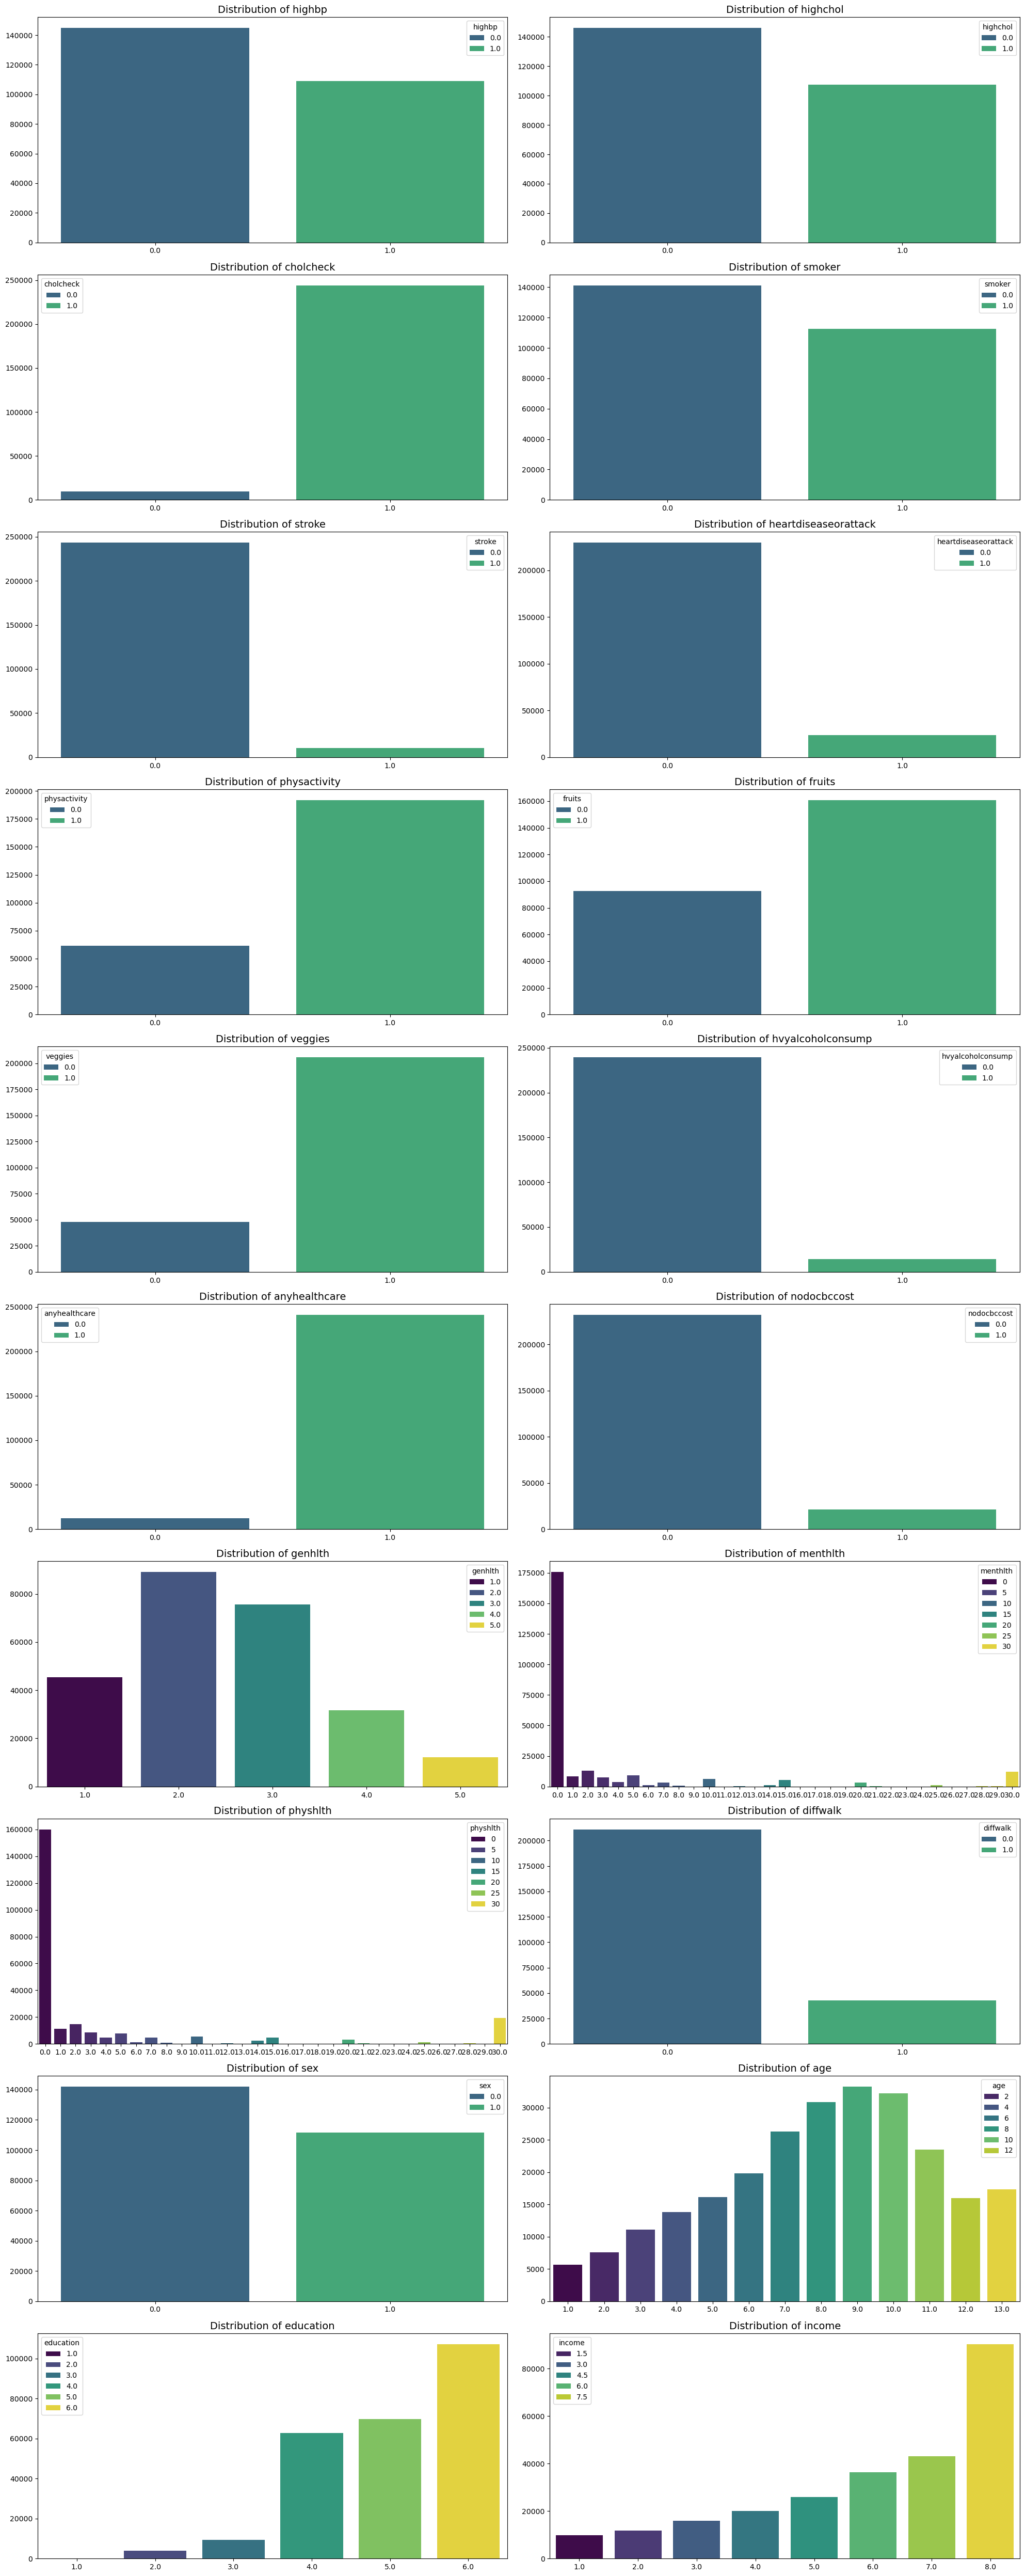

In [38]:
# Subplots
# List of all columns except targetDiabetes and BMI distribution 
cols_to_plot = [col for col in prediabetes_df.columns if col not in ['diabetes_012','bmi']]

# Grid Subplots
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(20, 50))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.countplot(x=col, data=prediabetes_df, ax=axes[i], hue=col, palette='viridis')
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

- Looking at the binary features: cholesterol , stroke, heart disease attack, heavy alcohol consumption, any healthcare and difficulty walking are highly imbalance.
- Income is a primary determinant of health and higher education correlates wiht higher health literacy.

### Correlation Heat Map

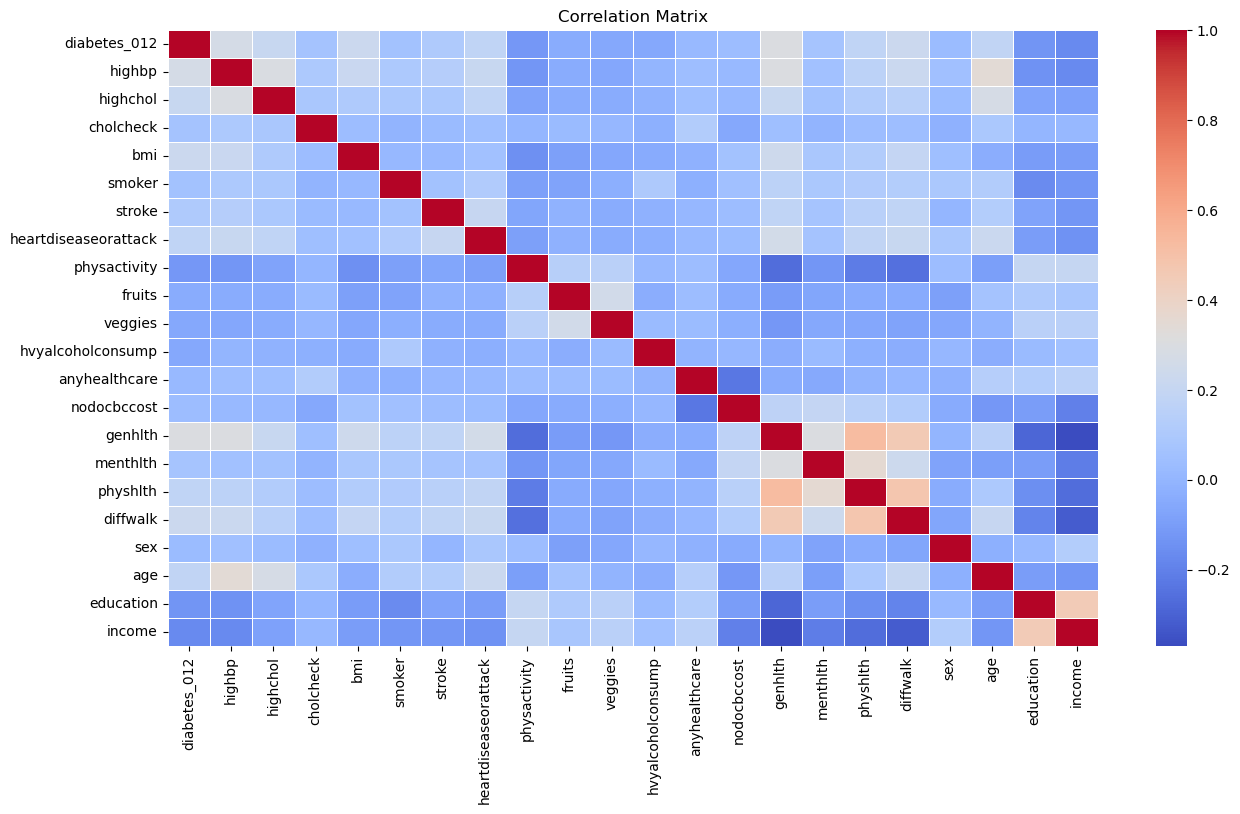

In [39]:
plt.figure(figsize=(15, 8))
sns.heatmap(prediabetes_df.corr(),  cmap='coolwarm', linewidths=0.5) #annot=False - show colors but dont write numbers in the square
plt.title('Correlation Matrix')

plt.show()


<Axes: >

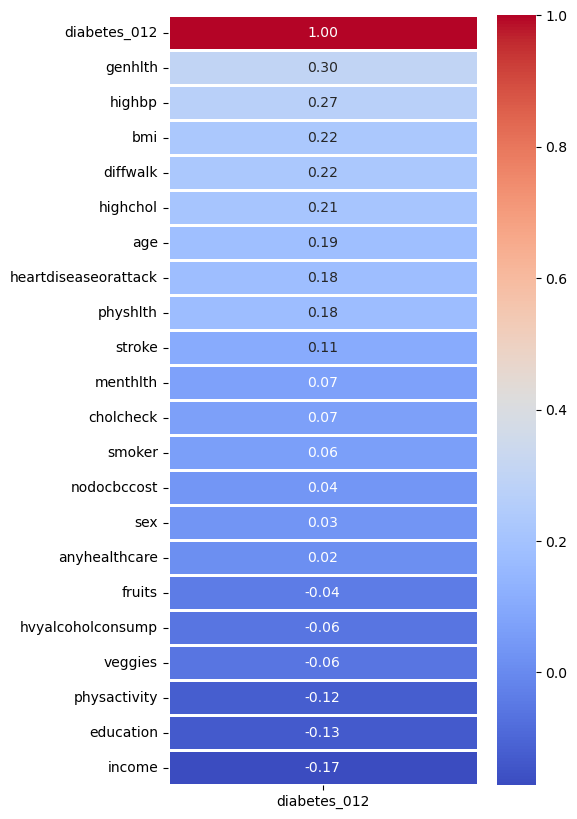

In [40]:
# Another Correlation heat map version 
# Plot for target y 
plt.figure(figsize=(5, 10))   # width/height
target_corr = prediabetes_df.corr()[['diabetes_012']].sort_values(by='diabetes_012', ascending=False)  # note to double bracket target diabetes_012

sns.heatmap(target_corr, annot=True, fmt=".2f", cmap='coolwarm', linewidth=1)

The correlation heatmap shows the top-5 strongest global predictors of diabetes: 
- genhlth(0.30), 
- highbp(0.27),
- bmi (0.22),
- diffwalk(0.22)
- highchol(0.21)


### 4. Data Cleaning and Preprocessing


In [41]:
# Check for missing values
prediabetes_df.isna().sum()


diabetes_012            0
highbp                  0
highchol                0
cholcheck               0
bmi                     0
smoker                  0
stroke                  0
heartdiseaseorattack    0
physactivity            0
fruits                  0
veggies                 0
hvyalcoholconsump       0
anyhealthcare           0
nodocbccost             0
genhlth                 0
menthlth                0
physhlth                0
diffwalk                0
sex                     0
age                     0
education               0
income                  0
dtype: int64

In [42]:
# Check for duplicates
prediabetes_df.duplicated().sum()

np.int64(23899)

In [43]:
# Inspect and verify duplicates
duplicates = prediabetes_df[prediabetes_df.duplicated(keep=False)]
duplicates

,diabetes_012,highbp,highchol,cholcheck,bmi,smoker,stroke,heartdiseaseorattack,physactivity,fruits,veggies,hvyalcoholconsump,anyhealthcare,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
25,0.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0
29,0.0,0.0,1.0,1.0,31.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
44,0.0,0.0,1.0,1.0,31.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
52,2.0,1.0,1.0,1.0,27.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,0.0,30.0,1.0,0.0,10.0,4.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253492,2.0,1.0,1.0,1.0,33.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,9.0,6.0,6.0
253550,0.0,0.0,0.0,1.0,25.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,6.0,8.0
253563,0.0,0.0,1.0,1.0,24.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,6.0,8.0
253597,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0


#### Inspect which class the duplicates belong to before dropping

In [44]:
# Check distribution of the Target within the duplicates
duplicate_rows = prediabetes_df[prediabetes_df.duplicated(keep=False)]

print(duplicate_rows['diabetes_012'].value_counts(normalize=True))

diabetes_012
0.0    0.986234
2.0    0.013652
1.0    0.000114
Name: proportion, dtype: float64


In [45]:
# Drop the duplicates 
# The percentage showed that majority of the duplicates are in the class 0(healthy) 
# and for class 1(prediabetes) it has almost no duplicates (0.0001).
prediabetes_df = prediabetes_df.drop_duplicates()


In [46]:
# Double-check duplicates after dropping
prediabetes_df.isnull().sum()

diabetes_012            0
highbp                  0
highchol                0
cholcheck               0
bmi                     0
smoker                  0
stroke                  0
heartdiseaseorattack    0
physactivity            0
fruits                  0
veggies                 0
hvyalcoholconsump       0
anyhealthcare           0
nodocbccost             0
genhlth                 0
menthlth                0
physhlth                0
diffwalk                0
sex                     0
age                     0
education               0
income                  0
dtype: int64

#### BMI Outliers

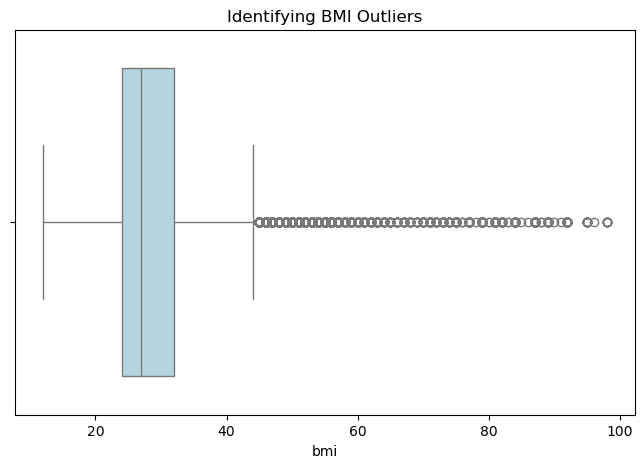

In [47]:
# Check BMI for outliers 
plt.figure(figsize=(8, 5))
sns.boxplot(x=prediabetes_df['bmi'], color='lightblue')
plt.title('Identifying BMI Outliers')
plt.show()

Notes: 
- BMI is calculated as: BMI =  weight / height
- A BMI of 80–99 is extremely high and rare.

Example: 
5'5" (65 inches)

BMI 80: ~480 lbs

BMI 99: ~594 lbs

- In medical terminology, a BMI over 60 is considered "super-super obese." Whether someone has a BMI of 65 or 95, their risk profile is effectively the same.
We will use 60 as our 'cutoff', we are telling the model that this is the maximum level of risk for the BMI feature.


In [48]:
# Check how many people have a BMI over 60
count = len(prediabetes_df[prediabetes_df['bmi'] > 60])
print(f"Number of People with BMI > 60: {count}")
print(f"Percentage: {(count / len(prediabetes_df)) * 100:.2f}%")

# If percentage < 1%: Safe to remove or cap them at 60.

Number of People with BMI > 60: 805
Percentage: 0.35%


In [49]:
# Remove people over 60 BMI, they are outliers. Resave to DataFrame
prediabetes_df = prediabetes_df[prediabetes_df['bmi'] <= 60]

In [50]:
# Verify outlier removal

count = len(prediabetes_df[prediabetes_df['bmi'] > 60])
print(f"Number of People with BMI > 60: {count}")

Number of People with BMI > 60: 0


### 5. Feature Engineering



**Cardiovascular Risk =  Combination of High BP and High Cholesterol**
- If a person has both, they are above the higher-risk threshold.
- The combination of High Blood Pressure and High Cholesterol is much more dangerous than either one alone. 
- This is often a precursor to prediabetes.

In [51]:
# 1 means they have both highbp and highchol
# 0 means they neither or only one of the two

prediabetes_df['cardiovascular'] = prediabetes_df['highbp'] * prediabetes_df['highchol']

In [52]:
# Drop the highbp and highcol after interaction
prediabetes_df = prediabetes_df.drop(columns=['highbp','highchol'])


**Feature Binning: Overweight(BMI 25–29.9) to Obese(BMI ≥ 30)**
- Overweight (BMI 25–29.9) - Insulin resistance can begin on this range.
- Obese (BMI ≥ 30) - Risk of insulin resistance increases substantially. Much higher chance of Prediabetes and Type 2 diabetes.
- In medical terms, a BMI of 30.0 marks the official transition from Overweight(BMI 25–29.9 to Obese (BMI ≥ 30). 
The body reacts differently to "Overweight vs. "Obese" thresholds. Binning helps it see these "cliff edges."

In [53]:
# Create an obese flag , 1 if BMI >= 30, else 0
# Prediabetics often sit right on the edge of clinical markers.
# By keeping bmi feature, the model sees the "sliding scale" of risk.

prediabetes_df['obese'] = (prediabetes_df['bmi'] >= 30.0).astype(float)


**Feature Engineering: Lifestyle Score:  Aggregate Healthy and Non-Healthy Lifestyles**
- healthy habits: fruits, veggies, physactivity
- non-healthy habits: smoker, hvyalcoholconsump
- Combining them together may tell a story


In [54]:
# Create new lifestyle feature column
prediabetes_df['lifestyle'] = (prediabetes_df['fruits'] + prediabetes_df['veggies'] + prediabetes_df['physactivity']
                            - prediabetes_df['smoker'] - prediabetes_df['hvyalcoholconsump'])

In [55]:
# Drop features after interaction
prediabetes_df = prediabetes_df.drop(columns=['fruits','veggies', 'physactivity', 'smoker', 'hvyalcoholconsump'])

In [56]:
# Verify maximum lifestyle value
prediabetes_df['lifestyle'].max()

3.0

In [57]:
# Display the new DataFrame with the newly created  and dropped columns

prediabetes_df.head(5)

,diabetes_012,cholcheck,bmi,stroke,heartdiseaseorattack,anyhealthcare,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income,cardiovascular,obese,lifestyle
0,0.0,1.0,40.0,0.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0,1.0,1.0,0.0
1,0.0,0.0,25.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,0.0,0.0,0.0
2,0.0,1.0,28.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0,1.0,0.0,1.0
3,0.0,1.0,27.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0,0.0,0.0,3.0
4,0.0,1.0,24.0,0.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0,1.0,0.0,3.0


#### Scaling 
##### - We don’t scale binary features because they are already in the most perfect format for a machine learning model.
##### - It is completely normal and expected to have negative values after scaling.

In [58]:
# Init the scaler
scaler = StandardScaler()

# Scale columns
scale_cols = ['age', 'education', 'income', 'bmi', 'genhlth', 'menthlth', 'physhlth','lifestyle']

# Scale and overwrite the columns in the DataFrame
prediabetes_df[scale_cols] = scaler.fit_transform(prediabetes_df[scale_cols])


In [59]:
# Display and review scaled DataFrame
prediabetes_df.head(5)

,diabetes_012,cholcheck,bmi,stroke,heartdiseaseorattack,anyhealthcare,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income,cardiovascular,obese,lifestyle
0,0.0,1.0,1.862008,0.0,0.0,1.0,0.0,2.255466,1.880933,1.143382,1.0,0.0,0.293782,-0.987719,-1.382502,1.0,1.0,-1.484890
1,0.0,0.0,-0.570792,0.0,0.0,0.0,1.0,0.375763,-0.454168,-0.516393,0.0,0.0,-0.352706,1.026871,-2.338743,0.0,0.0,-1.484890
2,0.0,1.0,-0.084232,0.0,0.0,1.0,1.0,2.255466,3.437667,2.803156,1.0,0.0,0.293782,-0.987719,1.008101,1.0,0.0,-0.565557
3,0.0,1.0,-0.246418,0.0,0.0,1.0,0.0,-0.564089,-0.454168,-0.516393,0.0,0.0,0.940269,-1.995014,0.051860,0.0,0.0,1.273108
4,0.0,1.0,-0.732978,0.0,0.0,1.0,0.0,-0.564089,-0.064985,-0.516393,0.0,0.0,0.940269,0.019576,-0.904381,1.0,0.0,1.273108


In [60]:
# Recalculate the correlation with the target
correlations = prediabetes_df.corr()['diabetes_012'].sort_values(ascending=False)

# Verify the new features correlations
print(correlations[['cardiovascular','obese', 'lifestyle']])

cardiovascular    0.267884
obese             0.194790
lifestyle        -0.075722
Name: diabetes_012, dtype: float64


In [61]:
print(correlations)

# Negative values are called Protective Factors

diabetes_012            1.000000
genhlth                 0.284223
cardiovascular          0.267884
bmi                     0.231282
diffwalk                0.209397
obese                   0.194790
age                     0.184894
heartdiseaseorattack    0.170710
physhlth                0.159256
stroke                  0.100307
cholcheck               0.075732
menthlth                0.057187
sex                     0.032643
anyhealthcare           0.024977
nodocbccost             0.023294
lifestyle              -0.075722
education              -0.107464
income                 -0.146330
Name: diabetes_012, dtype: float64


- Notice that the new engineered feature "cardiovascular" moved to the top predictors and "lifestyle" moved to the top protective factors

### 6. Data Splitting

In [62]:
# Split the input features and target
X = prediabetes_df.drop(['diabetes_012'], axis=1)
y = prediabetes_df['diabetes_012']

In [63]:
y.value_counts()

diabetes_012
0.0    189438
2.0     34926
1.0      4612
Name: count, dtype: int64

In [64]:
# Verify the input and engineered features
X.columns

Index(['cholcheck', 'bmi', 'stroke', 'heartdiseaseorattack', 'anyhealthcare',
       'nodocbccost', 'genhlth', 'menthlth', 'physhlth', 'diffwalk', 'sex',
       'age', 'education', 'income', 'cardiovascular', 'obese', 'lifestyle'],
      dtype='object')

In [65]:
# Split the data with 15% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

### 7. Model Selection

#### DummyClassifier                            
- produce Baseline model

In [66]:
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train, y_train) 
dummy_pred = dummy_clf.predict(X_test)
# Classification report
print("--- Dummy Baseline ---")
print(classification_report(y_test, dummy_pred, zero_division=0))

--- Dummy Baseline ---
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91     28416
         1.0       0.00      0.00      0.00       692
         2.0       0.00      0.00      0.00      5239

    accuracy                           0.83     34347
   macro avg       0.28      0.33      0.30     34347
weighted avg       0.68      0.83      0.75     34347



- The Recall of 0.00 for Class 1 (Prediabetes) and Class 2 (Diabetes) proves that the Dummy Baseline model is completely blind to the very people we are trying to help.
- The 83% accuracy score is simply guessing "Healthy" for everyone.

#### Logistic Regression
- using multinomial

In [67]:
# multi_class='multinomial' param was deprecated 
# Setting class weight balanced
log_reg = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=42)

# Train and Predict
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.65      0.77     28416
         1.0       0.03      0.28      0.05       692
         2.0       0.36      0.57      0.44      5239

    accuracy                           0.63     34347
   macro avg       0.44      0.50      0.42     34347
weighted avg       0.83      0.63      0.70     34347



- Our model now has a Recall of 0.28 for Class 1.
- This means we have successfully identified 28% of the prediabetics that the baseline completely missed.
- In a clinical setting, that 28% can now be warned to change their lifestyle before they hit Type 2 Diabetes.

### TO BE CONTINUED...

### 8. Hyperparameter Tuning



### 9. Model Evaluation



### 10. Model Interpretation and Explainability


### 11. Model Validation and Testing

